# CoCliCo --- Delft Notebook Demonstration (October 2023)

Coastal Climate Core Services (CoCliCo) is an European effort to develop an opean web-platform to aid decision making on coastal risk (2021 - 2025). Please have a look at our [website](https://coclicoservices.eu/) to find out more about the project. 

During this project several datasets will be made available, which can be explored on the platform as well as accessed via cloud-storage buckets. In this notebook, some examples are provided on how to interact with the data using Python, specifically for sea level rise projections from the Intergovernmental Panel on Climate Change (IPCC) at national scales.

- Notebook author: Etiënne Kras, September 13th 2023

### Software environment

- Please install the latest mambaforge package manager by downloading the executable from the [MiniForge GitHub repo](https://github.com/conda-forge/miniforge#mambaforge) for your Operating System. 
- Clone the [coclicodata GitHub repo](https://github.com/openearth/coclicodata) on your local desktop using Git or GitHub Desktop.
- Open a Miniforge Prompt (terminal) on your local desktop. 
- Navigate to the coclicodata GitHub repo in the Miniforge Prompt and run `mamba env create -f environment.yml`. 
- This may take a few minutes to complete but once it is finished you will have all required packages to run this notebook installed in your ‘coclico’ environment. 

## IPCC AR5 & AR6 sea level rise projections 

Here, we use [IPCC's](https://www.ipcc.ch/) Fifth Assessment Report (AR5, 2013) relative Sea Surface Height (SSH) data processed by the [Integrated Climate Data Center (ICDC, CEN, University of Hamburg)](https://www.cen.uni-hamburg.de/en/icdc/data/ocean/ar5-slr.html). The data includes ten geophysical sources that drive long-term changes in relative sea level change; five ice components, three ocean-related components, a land water storage and glacial isostatic adjustment. Also, we consider IPCC's latest medium confidence relative median regional sea level projections published in the Sixth Assessment Report (AR6, 2021) processed by [NASA's Jet Propulsion Laboratory](https://podaac.jpl.nasa.gov/announcements/2021-08-09-Sea-level-projections-from-the-IPCC-6th-Assessment-Report). The data includes antarctic ice sheet, greenland ice sheet, glaciers, land-water storage, ocean dynamics and vertical land motion as six geophysical sources that drive long-term changes. 

The data is hosted in cloud buckets as Cloud Optimized GeoTIFFs (COGs). [COG](https://www.cogeo.org/) is a regular GeoTIFF file (viewed in for instance QGIS) but aimed at being hosted on a HTTP file server, with an internal organization that enables more efficient workflows in the cloud. You can basically ask for parts of the file you need which make post-processing routines very fast.

This notebook follows protocols for both visuals ([IPCC's Style Guide](https://www.ipcc.ch/site/assets/uploads/2022/09/IPCC_AR6_WGI_VisualStyleGuide_2022.pdf)) and for describing uncertainty ([AR5 WG1 CH13 SM](https://www.climatechange2013.org/images/report/WG1AR5_Ch13SM_FINAL.pdf) & [AR6 WG1 CH9 SM](https://www.ipcc.ch/report/ar6/wg1/downloads/report/IPCC_AR6_WGI_Chapter09_SM.pdf)). Results can be compared to the official [IPCC Atlas](https://interactive-atlas.ipcc.ch/) (see [documentation](https://www.ipcc.ch/report/ar6/wg1/downloads/report/IPCC_AR6_WGI_Atlas.pdf)).



## KNMI's Climate Scenarios

[KNMI](https://www.knmi.nl/over-het-knmi/about) is the national data and knowledge institute for climate science in the Netherlands. As an agency of the Ministry of Infrastructure and the Environment, KNMI advises the Dutch government on climate change. Being a scientific institute, KNMI also contributes to international climate research and represents the Netherlands in the IPCC. KNMI also produces climate scenarios for the Netherlands, which provide an applied product to policy advisors and other professionals to help them taking appropriate decisions for a safe and sustainable Netherlands in a changing climate. These Dutch climate scenarios follow approximately a just after each IPCC assessment cycle and are in line with the trend identified therein, yet further detailed for the Dutch situation. 

[KNMI'14](https://cdn.knmi.nl/system/data_center_publications/files/000/070/807/original/Brochure_KNMI14_EN_2015.pdf?1653079346) are the most up-to-date climate scenarios related to IPCC's AR5 from 2013. This data is imported in this notebook as comparison to IPCC's AR5 and AR6 data. KNMI'23 will be published on October 9th 2023 and are related to IPCC's AR6 from 2023. 

### Imports

In [1]:
import warnings

# import holoviews as hv
import cartopy.crs as ccrs
import cartopy.feature as cf
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
import numpy as np
import shapely
import pandas as pd
import pystac_client
import xarray as xr
import rioxarray as rio
import pathlib

#import colormaps as cmaps
import pyam # https://pyam-iamc.readthedocs.io/en/latest/index.html
import matplotlib.colors as mcolors

from copy import deepcopy
from typing import List, Dict

# ignore warnings
warnings.filterwarnings("ignore")

<IPython.core.display.Javascript object>

### CoCliCo STAC catalog

In [3]:
# load the CoCliCo STAC catalog
catalog = pystac_client.Client.open(
    "https://storage.googleapis.com/dgds-data-public/coclico/coclico-stac/catalog.json"
)
# catalog

# list the datasets present in the catalog, we are interested in the slp5 and slp6 sets
list(catalog.get_children())

[<CollectionClient id=ssl>,
 <CollectionClient id=wef>,
 <CollectionClient id=eesl>,
 <CollectionClient id=floodmaps>,
 <CollectionClient id=sc>,
 <CollectionClient id=cbca>,
 <CollectionClient id=coastal-mask>,
 <CollectionClient id=smd>,
 <CollectionClient id=cisi>,
 <CollectionClient id=slp5>,
 <CollectionClient id=slp6>,
 <CollectionClient id=cfr>,
 <CollectionClient id=slp6_pilot>]

### Define parameter space

In [4]:
yr = 2100  # set year
ens = 50  # set ensemble [0-100]
var = "slr"  # set variable
ccs5 = "26"  # set climate change scenario for AR5
ccs6 = "1-26"  # set climate change scenario for AR6

### Filter datasets

In [5]:
# define function(s)

# function to put items in dataframe
def items_to_dataframe(items: List[Dict]) -> pd.DataFrame:
    """STAC items to Pandas dataframe.

    Args:
        items (List[Dict]): _description_

    Returns:
        pd.DataFrame: _description_
    """
    _items = []
    for i in items:
        _i = deepcopy(i)
        # _i['geometry'] = shape(_i['geometry'])
        # ...  # for example, drop some attributes that you're not interested in
        _items.append(_i)
    df = pd.DataFrame(pd.json_normalize(_items))
    # for field in ["properties.datetime"]:
    #     if field in df:
    #         df[field] = pd.to_datetime(df[field])
    # df = df.sort_values("properties.datetime")
    return df

In [6]:
%%time
# read STAC items as Pandas dataframe

# AR5, takes a while +/- 1 min
ar5_col = catalog.get_child("slp5")
items_ar5 = list(ar5_col.get_items()) # this is slow as we need to list all items
items_ar5_df = items_to_dataframe([i.to_dict() for i in items_ar5])

# AR6, takes a while +/- 6 min
ar6_col = catalog.get_child("slp6")
items_ar6 = list(ar6_col.get_items()) # this is slow as we need to list all items
items_ar6_df = items_to_dataframe([i.to_dict() for i in items_ar6])

CPU times: total: 2min 42s
Wall time: 7min 11s


In [7]:
# filter items in datasets

# define variables
ens_list = ["5", "50", "95"]  # ensemble list to look into
yrs_list = np.arange(1970, 2200, 10)  # years to look into (step of 10 years from 1970)
key_list = ["CCS", "YRS", "ENS"]

# index AR5 dataframe on criteria
fil_idx5  = []
AR5_dict = {key: [] for key in key_list}
for idx, i in enumerate(items_ar5_df.id):
    enss = str(i).split("/")[1].split("ens")[-1]  # ensemble
    yrs = int(str(i).split("/")[2][0:4])  # yrs
    ccs = str(i).split("/")[0].split("=")[-1] # ccs
    if enss in ens_list and yrs in yrs_list:  # constraining read ensembles and years
        AR5_dict["CCS"].append(ccs)
        AR5_dict["YRS"].append(yrs)
        AR5_dict["ENS"].append(enss)
        fil_idx5.append(idx)

# index AR6 dataframe on criteria
fil_idx6 = []
AR6_dict = {key: [] for key in key_list}
for idx, i in enumerate(items_ar6_df.id):
    enss = str(i).split("/")[1].split("ens")[-1]  # ensemble
    yrs = int(str(i).split("/")[2][0:4])  # yrs
    ccs = str(i).split("/")[0].split("=")[-1] # ccs
    if enss in [str(float(x)) for x in ens_list] and yrs in yrs_list:  # constraining read ensembles and years
        AR6_dict["CCS"].append(ccs)
        AR6_dict["YRS"].append(yrs)
        AR6_dict["ENS"].append(enss)
        fil_idx6.append(idx)

# filter AR5 dataframe and STAC items on index
items_df_fil5 = items_ar5_df.filter(items = fil_idx5, axis=0)
items_fil5 = [items_ar5[i] for i in fil_idx5]

# filter AR6 dataframe and STAC items on index
items_df_fil6 = items_ar6_df.filter(items = fil_idx6, axis=0)
items_fil6 = [items_ar6[i] for i in fil_idx6]

### Geospatial plot

In [8]:
# get data

# get AR5 collection and item href
for i in items_fil5:
    if i.id == r"rcp=%s/%s_ens%s/%s-01-01_%s-01-01.tif" % (ccs5, var, int(ens), yr, yr + 1):
        ar5_item_href = i.assets["data"].href

ar5_item = rio.open_rasterio(ar5_item_href, masked=True)

# get AR6 collection and item href
for i in items_fil6:
    if i.id == r"ssp=%s/%s_ens%s/%s.tif" % (ccs6, var, float(ens), yr):
        ar6_item_href = i.assets["data"].href

ar6_item = rio.open_rasterio(ar6_item_href, masked=True)
ar6_item_corr = ar6_item / 1000

# cbar limits
vmin = max(
    min(np.nanmin(ar5_item), np.nanmin(ar6_item_corr)), -0.2
)  # bound to -0.2 if smaller than this value
vmax = max(np.nanmax(ar5_item), np.nanmax(ar6_item_corr))

# colormap
cwd = pathlib.Path().resolve().parent
slev_divl = np.loadtxt(str(pathlib.Path.joinpath(cwd, r"src/coclico/colormaps/slev_div.txt")))
slev_div = mcolors.LinearSegmentedColormap.from_list('slev_div', slev_divl/255)

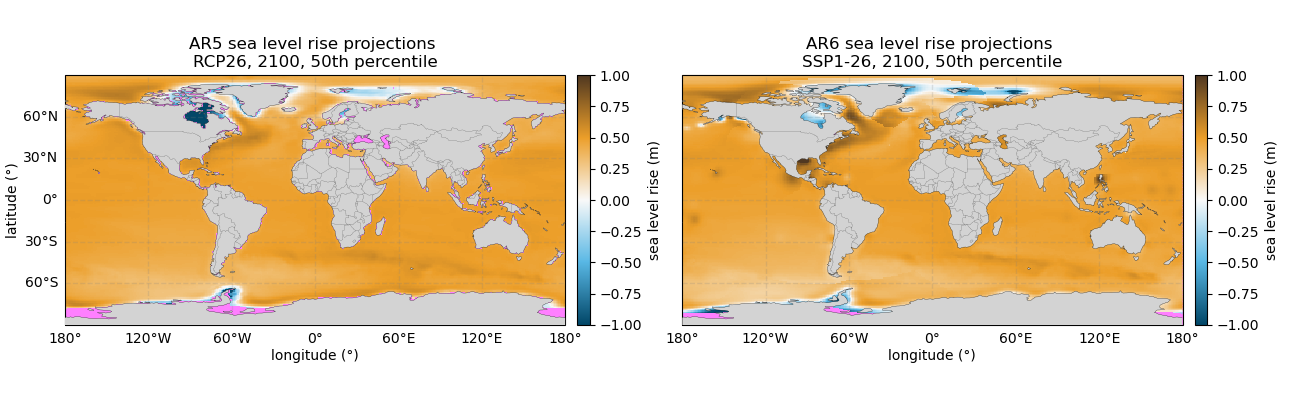

In [72]:
%matplotlib ipympl
# %matplotlib inline

# TODO: make plots with holoviews iso matplotlib
# TODO: zoom with ipyleaflet and converted bbox to this plot?
# TODO: zoom to same extent (sharex, sharey does not work properly) when selecting a boundings box in ipympl

# define figure
fig, (ax1, ax2) = plt.subplots(
    1, 2, figsize=(13, 4), subplot_kw={"projection": ccrs.PlateCarree()}
)  # , sharex=True, sharey=True)
fig.tight_layout()
# plt.gcf().subplots_adjust(bottom=0.05)
plt.gcf().subplots_adjust(left=0.05)

# populate AR5 plot
ax1.set_facecolor((1.0, 0.0, 1.0, 0.5)) 
im5 = ar5_item.plot(
    ax=ax1,
    add_colorbar=False,
    vmin=-1, #round(vmin, 2),
    vmax=1, #round(vmax, 2),
    cmap=slev_div,
)
ax1.set_title("%s \nRCP%s, %s, %sth percentile" % (ar5_col.title, ccs5, yr, ens))
# ax1.set_xlabel("Longitude [Degrees East]") # TODO: possibly import from file?
# ax1.set_ylabel("Latitude [Degrees North]") # TODO: possibly import from file?
cbar5 = plt.colorbar(im5, shrink=0.675, aspect=30 * 0.675, pad=0.02)
cbar5.set_label(
   "sea level rise (%s)" % ar5_col.extra_fields["deltares:units"]
)  # TODO: possibly import from file?
ax1.add_feature(cf.LAND, facecolor="lightgrey", zorder=15)
ax1.add_feature(cf.COASTLINE, linewidth=0.2, zorder=16)
ax1.add_feature(cf.BORDERS, linewidth=0.1, zorder=16)
gl1 = ax1.gridlines(
    crs=ccrs.PlateCarree(),
    draw_labels=True,
    linewidth=1,
    color="gray",
    alpha=0.2,
    linestyle="--",
)
gl1.xlabels_top = False
gl1.ylabels_right = False
ax1.text(
    -0.09,
    0.5,
    "latitude (°)",
    va="bottom",
    ha="center",
    rotation="vertical",
    rotation_mode="anchor",
    transform=ax1.transAxes,
)
ax1.text(
    0.5,
    -0.15,
    "longitude (°)",
    va="bottom",
    ha="center",
    rotation="horizontal",
    rotation_mode="anchor",
    transform=ax1.transAxes,
)

# populate AR6 plot
ax2.set_facecolor((1.0, 0.0, 1.0, 0.5))
im6 = ar6_item_corr.plot(
    ax=ax2,
    add_colorbar=False,
    vmin=-1, #round(vmin, 2),
    vmax=1, #round(vmax, 2),
    cmap=slev_div,
)
ax2.set_title("%s \nSSP%s, %s, %sth percentile" % (ar6_col.title, ccs6, yr, ens))
# ax2.set_xlabel("Longitude [Degrees East]") # TODO: possibly import from file?
# ax2.set_ylabel("") # leave empty
cbar6 = plt.colorbar(im6, shrink=0.675, aspect=30 * 0.675, pad=0.02)
cbar6.set_label(
    "sea level rise (%s)" % ar5_col.extra_fields["deltares:units"] # take AR5 unit as we divided by 1000
)  # TODO: possibly import from file?
ax2.add_feature(cf.LAND, facecolor="lightgrey", zorder=15)
ax2.add_feature(cf.COASTLINE, linewidth=0.2, zorder=16)
ax2.add_feature(cf.BORDERS, linewidth=0.1, zorder=16)
gl2 = ax2.gridlines(
    crs=ccrs.PlateCarree(),
    draw_labels=True,
    linewidth=1,
    color="gray",
    alpha=0.2,
    linestyle="--",
)
gl2.xlabels_top = False
gl2.ylabels_right = False
gl2.ylabels_left = False
ax2.text(
    0.5,
    -0.15,
    "longitude (°)",
    va="bottom",
    ha="center",
    rotation="horizontal",
    rotation_mode="anchor",
    transform=ax2.transAxes,
);

### Temporal plot

In [60]:
# select a point to plot timeseries of SLR projections for
point_location = [4.2, 52.8] #[4.2, 52.8] #[3.6, 52.0] #[-1.0, 50.0] # [-2, 44.0] # easting, norting 
point_geom = shapely.Point(point_location)

# TODO: enable computing the mean of multiple cells in a polygon or specified set of points and show the SLR projection timeseries
area_location = [4.4, 52.6, 5.4, 53]
area_geom = shapely.box(*area_location)

In [61]:
# KNMI input (klimaatscenarios)

# TODO: insert KNMI'23 data (Bart / Quirijn info)

# 2014 data (related to AR5, in m)
WGHL_2030l = 0.1 
WGHL_2030h = 0.25
GLGH_2050l = 0.15  
GLGH_2050h = 0.3
GLGH_2085l = 0.25 
GLGH_2085h = 0.6
WLWH_2050l = 0.2 
WLWH_2050h = 0.4
WLWH_2085l = 0.45
WLWH_2085h = 0.8

# 2023 data (related to AR6, in m)

In [62]:
# retrieve AR5 and AR6 data at above-defined location

# pre-processing function
def preprocess5(ds):
    if point_location[0] < 0: # replace x loc < 0 by positive value [0-360]
        point_location[0] = point_location[0] + 360

    point_geom = shapely.Point(point_location)
    
    ds = (
        ds.rio.clip([point_geom])
        .sel(x=point_location[0], y=point_location[1], method="nearest")
    )

    return ds

# pre-processing function
def preprocess6(ds):
    if point_location[0] > 180: # replace x loc > 180 by negative value [-180, 180]
        point_location[0] = point_location[0] - 360

    point_geom = shapely.Point(point_location)
    
    ds = (
        ds.rio.clip([point_geom])
        .sel(x=point_location[0], y=point_location[1], method="nearest")
    )

    return ds

# concat datasets
selected_ds5 = xr.open_mfdataset(
    [i.assets["data"].href for i in items_fil5],
    engine="rasterio",
    concat_dim="band",
    combine="nested",
    preprocess=preprocess5,  # this indexes every before merging them
    parallel=True, # this is for Dask
)

selected_ds6 = xr.open_mfdataset(
    [i.assets["data"].href for i in items_fil6],
    engine="rasterio",
    concat_dim="band",
    combine="nested",
    preprocess=preprocess6,  # this indexes every before merging them
    parallel=True, # this is for Dask
)

# add ds information to dictionaries
AR5_dict["SLR"] = selected_ds5["band_data"].values
AR6_dict["SLR"] = selected_ds6["band_data"].values/1000

# convert dict to dataframe
df5 = pd.DataFrame(data=AR5_dict)
df6 = pd.DataFrame(data=AR6_dict)

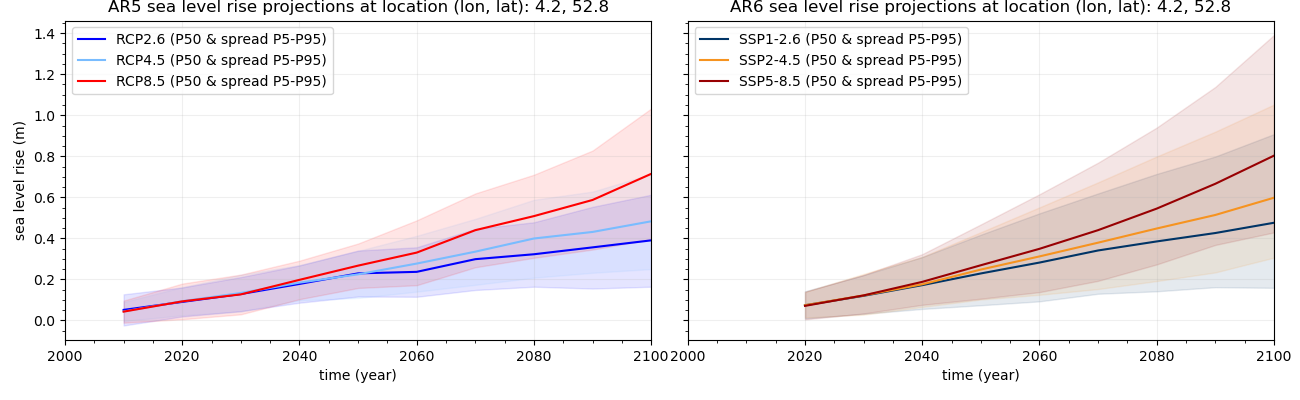

In [71]:
%matplotlib ipympl
# %matplotlib inline

# TODO: incorporate historic sea level rise (observation) data?

# toggles
xmax = 2100
ar5_disp_knmi14 = False
ar6_disp_knmi14 = False

# define figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 4), sharey=True, sharex=True)
fig.tight_layout()
plt.gcf().subplots_adjust(bottom=0.15)
plt.gcf().subplots_adjust(left=0.05)
ax = plt.gca()

# specify colors for plots, different for AR5 & AR6 following IPCC figures
colors = pyam.plotting.PYAM_COLORS # official color package
#pd.DataFrame({'name': list(colors.keys()), 'color': list(colors.values())})
#colorsAR5 = [[0,52,102], [112,160,205], [149,27,30]]
#colorsAR6 = [[23,60,102], [247,148,32], [149,27,30]]

# AR5
for idx, (scen, grp) in enumerate(df5[df5.YRS <= xmax].groupby(["CCS"])):  # group per scenario
    ens_list = list(grp.groupby("ENS"))
    ens_list[1][1].plot(
        kind="line",
        x="YRS",
        y="SLR",
        label="RCP%s (P50 & spread P5-P95)" % (scen[0][0] + "." + scen[0][1]),
        color=colors["AR5-RCP-"+str(scen[0][0:-1]) + "." +str(scen[0][-1])],#np.array(colorsAR5[idx])/255,
        ax=ax1,
        alpha=1.0,
    )  # mean 50 percentile
    ax1.fill_between(
        ens_list[0][1].YRS,
        ens_list[0][1].SLR,
        ens_list[2][1].SLR,
        alpha=0.1,
        color=colors["AR5-RCP-"+str(scen[0][0:-1]) + "." +str(scen[0][-1])],#np.array(colorsAR5[idx])/255,
        interpolate=True,
    )  # 5-95th percentile shading

ax1.set_title(
    "AR5 sea level rise projections at location (lon, lat): %s, %s" % (point_location[0], point_location[1])
)
ax1.xaxis.set_minor_locator(tck.AutoMinorLocator())
ax1.yaxis.set_minor_locator(tck.AutoMinorLocator())
#ax1.axvline(2020, linestyle="--", color="k", linewidth=1, alpha=0.2)
#ax1.axvline(2100, linestyle="--", color="k", linewidth=1, alpha=0.2)
ax1.set_xlim(2000, xmax)
ax1.grid(alpha=0.2)
ax1.set_xlabel("time (year)")
ax1.set_ylabel("sea level rise (m)")

# KNMI'14 data
if ar5_disp_knmi14:
    ax1.vlines(x=2029.8, ymin=WGHL_2030l, ymax=WGHL_2030h, color=colors["AR5-RCP-4.5"], linewidth=2, linestyle=":", alpha=0.8)
    ax1.vlines(x=2049.8, ymin=GLGH_2050l, ymax=GLGH_2050h, color=colors["AR5-RCP-4.5"], linewidth=2, linestyle=":", alpha=0.8)
    ax1.vlines(x=2084.8, ymin=GLGH_2085l, ymax=GLGH_2085h, color=colors["AR5-RCP-4.5"], linewidth=2, linestyle=":", alpha=0.8)
    ax1.vlines(x=2030.2, ymin=WGHL_2030l, ymax=WGHL_2030h, color=colors["AR5-RCP-8.5"], linewidth=2, linestyle=":", alpha=0.8)
    ax1.vlines(x=2050.2, ymin=WLWH_2050l, ymax=WLWH_2050h, color=colors["AR5-RCP-8.5"], linewidth=2, linestyle=":", alpha=0.8)
    ax1.vlines(x=2085.2, ymin=WLWH_2085l, ymax=WLWH_2085h, color=colors["AR5-RCP-8.5"], linewidth=2, linestyle=":", alpha=0.8)
    ax1.fill_between(x=[2016,2045], y1=WGHL_2030l, y2=WGHL_2030h, color=colors["AR5-RCP-4.5"], linewidth=2, alpha=0.1, linestyle=":", label="KNMI'14 - RCP4.5 (G) low-high")
    ax1.fill_between(x=[2036,2065], y1=GLGH_2050l, y2=GLGH_2050h, color=colors["AR5-RCP-4.5"], linewidth=2, alpha=0.1, linestyle=":")
    ax1.fill_between(x=[2071,2100], y1=GLGH_2085l, y2=GLGH_2085h, color=colors["AR5-RCP-4.5"], linewidth=2, alpha=0.1, linestyle=":")
    ax1.fill_between(x=[2016,2045], y1=WGHL_2030l, y2=WGHL_2030h, color=colors["AR5-RCP-8.5"], linewidth=2, alpha=0.1, linestyle=":", label="KNMI'14 - RCP8.5 (G) low-high")
    ax1.fill_between(x=[2036,2065], y1=WLWH_2050l, y2=WLWH_2050h, color=colors["AR5-RCP-8.5"], linewidth=2, alpha=0.1, linestyle=":")
    ax1.fill_between(x=[2071,2100], y1=WLWH_2085l, y2=WLWH_2085h, color=colors["AR5-RCP-8.5"], linewidth=2, alpha=0.1, linestyle=":")
    
ax1.legend(loc="upper left")

# AR6
for idx, (scen, grp) in enumerate(df6[df6.YRS <= xmax].groupby(["CCS"])):  # group per scenario
    ens_list = list(grp.groupby("ENS"))
    ens_list[1][1].plot(
        kind="line",
        x="YRS",
        y="SLR",
        label="SSP%s (P50 & spread P5-P95)" % (scen[0][0:3] + "." + scen[0][3]),
        color=colors["AR6-SSP"+str(scen[0][0:-1]) + "." +str(scen[0][-1])],#np.array(colorsAR6[idx])/255,
        ax=ax2,
        alpha=1.0,
    )  # mean 50 percentile
    ax2.fill_between(
        ens_list[0][1].YRS,
        ens_list[0][1].SLR,
        ens_list[2][1].SLR,
        alpha=0.1,
        color=colors["AR6-SSP"+str(scen[0][0:-1]) + "." +str(scen[0][-1])],#np.array(colorsAR6[idx])/255,
        interpolate=True,
    )  # 5-95th percentile shading

ax2.set_title(
    "AR6 sea level rise projections at location (lon, lat): %s, %s" % (point_location[0], point_location[1])
)

#ax2.axvline(2020, linestyle="--", color="k", linewidth=1, alpha=0.2)
#ax2.axvline(2100, linestyle="--", color="k", linewidth=1, alpha=0.2)
ax2.grid(alpha=0.2)
ax2.set_xlabel("time (year)")

# KNMI'14 data
if ar6_disp_knmi14:
    ax2.vlines(x=2029.8, ymin=WGHL_2030l, ymax=WGHL_2030h, color='cyan', linewidth=2, linestyle=":", alpha=0.8, label="KNMI'14 - RCP4.5 (G) low-high")
    ax2.vlines(x=2030.2, ymin=WGHL_2030l, ymax=WGHL_2030h, color='red', linewidth=2, linestyle=":", alpha=0.8, label="KNMI'14 - RCP8.5 (W) low-high")
    ax2.vlines(x=2049.8, ymin=GLGH_2050l, ymax=GLGH_2050h, color='cyan', linewidth=2, linestyle=":", alpha=0.8)
    ax2.vlines(x=2084.8, ymin=GLGH_2085l, ymax=GLGH_2085h, color='cyan', linewidth=2, linestyle=":", alpha=0.8)
    ax2.vlines(x=2050.2, ymin=WLWH_2050l, ymax=WLWH_2050h, color='red', linewidth=2, linestyle=":", alpha=0.8)
    ax2.vlines(x=2085.2, ymin=WLWH_2085l, ymax=WLWH_2085h, color='red', linewidth=2, linestyle=":", alpha=0.8)

ax2.legend(loc="upper left")

In [1]:
# TODO: comparison of AR5 / AR6 to the global mean at the selected location?
# TODO: restructure into story maps; require input from Quirijn (RWS, The Netherlands) & BRGM (France)

### Export notebook

In [ ]:
# TODO: export to HTML to try out an interactive example in which you can alter the clicked point to look at SLR projections